In [1]:
%load_ext autoreload
%autoreload 2

In collaboration with:

<div style="display: flex; align-items: center; gap: 10px;">
  <img src="fig/KUL_logo.png" width=25%>
  <img src="fig/Airbus_Logo.png" width=25%>
  <img src="fig/TUPLES_logo.webp", width=25%>
</div>

# Interactive and Explainable Allocation

Apart from providing (optimal) solutions to the scheduling and allocation problem, we aim to offer decision support in case of disrupted schedules due to unforeseen circumstances.
Examples of such disruptions can be the delay of a part delivery, human or logistical resource disruptions, adversarial weather conditions, etc.
Currently, transportation tasks are manually allocated and scheduled upfront by a team of planners.
These planners also coordinate the fine-grained synchronization among teams, to ensure the precedences of tasks are satisfied.
During the working day, they continuously monitor real-time updates and adjust schedules as needed to handle unforeseen events or disruptions.
These disruptions can arise for multiple reasons, including:

- **Weather-related disruptions:** Extreme wind or rain prevents the use of some hangars.
- **External logistics disruptions:** Delays or cancellations from third-party suppliers impact the arrival time of essential parts.
- **Human resource disruptions:** Unexpected worker absences, team meetings or fire-drills in a hangar temporarily reduces workforce availability.
- **Material availability disruptions** Vehicles like trucks or trailers may become temporarily unavailable due to technical breakdowns, accidents or maintenance operations.
- ...

In this notebook, we show some of the tooling implemented in CPMpy, which can be used to generate explanations of infeasible schedules, after disruptions occur.


In [2]:
import cpmpy as cp
from models import AllocationModel, SchedulingModel
from explain import FeasibilityResotorationModel

### Loading the data

In [3]:
from utils import read_instance

instance = f"data/anon_jsons/instance_96.json"
tasks, calendars, same_allocation = read_instance(instance)

print(f"Planning {len(tasks)} tasks")
tasks.head()

Planning 83 tasks


,task_id,duration,team_ids,original_start,original_end,release_date,due_date,successors
0,99549,30,"{fb668, f14cb, bf019, a559c, 39916, 0611a, 179...",0.0,30.0,0.0,60.0,{}
1,15760,15,"{fb668, f14cb, bf019, a559c, 39916, 0611a, 179...",16.0,31.0,0.0,61.0,{}
2,37628,30,"{fb668, f14cb, bf019, a559c, 39916, 0611a, 179...",19.0,49.0,0.0,79.0,{50284}
3,89518,15,"{fb668, f14cb, bf019, a559c, 39916, 0611a, 179...",37.0,52.0,7.0,82.0,{81613}
4,61595,45,"{fb668, f14cb, bf019, a559c, 39916, 0611a, 179...",14.0,59.0,0.0,89.0,{}


### Solving the allocation problem

Similar to what is done in `example_solve.ipynb`, we first optimize the number of teams required to plan all tasks, and then minimize the dispersion working-time (lexicographic optimization)

Objective value: 7
Objective value: 2


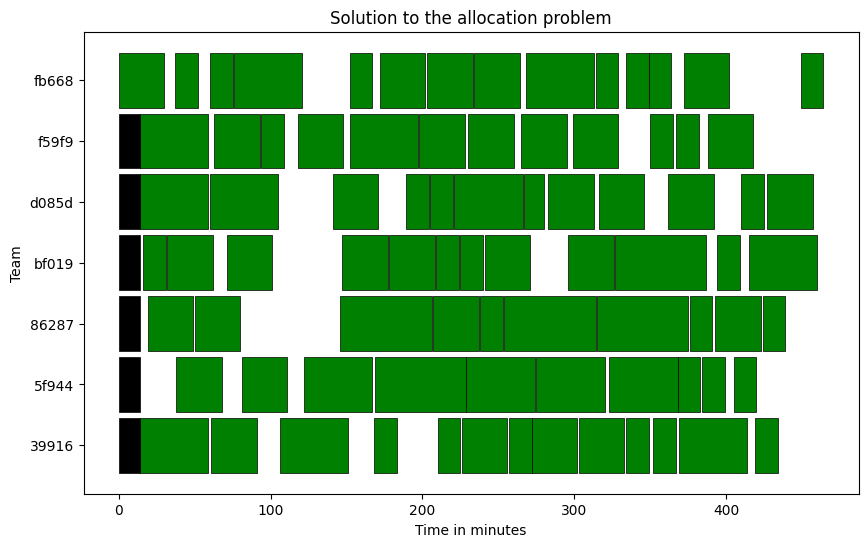

In [4]:
model = AllocationModel(tasks, calendars, same_allocation)
model.set_lexico_objectives([
    model.get_nb_teams_objective(),
    model.get_dispersion_objective()
])

model.solve(time_limit=5) # time limit of 5s for demo

orig_sol = model.get_solution()
fig, ax= model.visualize_solution()

## Disruptions

The above allocation is optimal given the calendars and skills of the working-teams.

However, during the day, a disruption may occur.
Below, we randomly generate a disruption where two teams are affected at the same time.
This can for example happen when two teams are working in the same hangar where a fire-drill is occuring


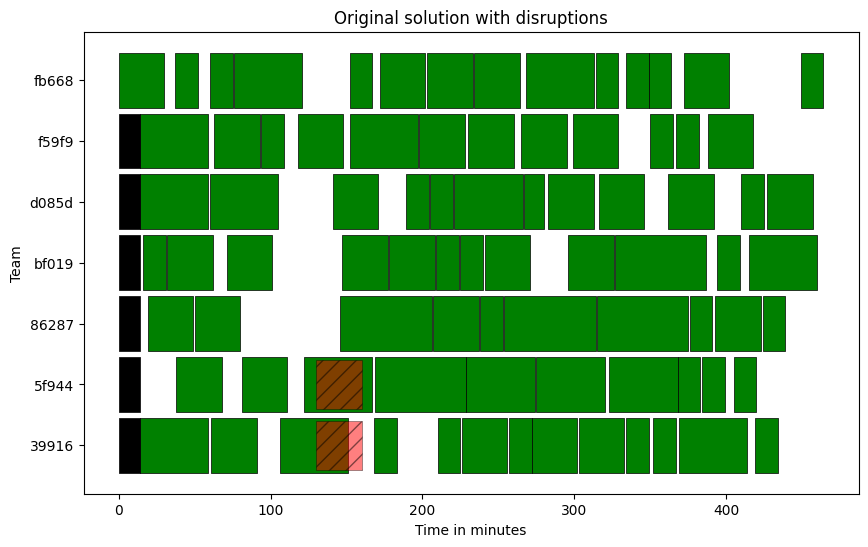

In [5]:
from generator import generate_disruption
import pandas as pd

disruption = generate_disruption(
    num_disruptions=(1,1), num_teams_affected=(2,2), duration=(30,),
    horizon=orig_sol.end.max(), teams=list(orig_sol['assigned_team'].unique()),
    seed = 1
)

model = FeasibilityResotorationModel(tasks, calendars, same_allocation, disruption=disruption)
model.set_original_solution(orig_sol)

fig, ax = model.visualize_original_solution_with_disruptions()


## Generating explanations

Large disruptions can impact the predefined plan in such a way that the set of disrupted tasks cannot be reallocated to other teams.
That is, a task that was originally assigned to a now disrupted team cannot be reassigned as all other compatible teams are already occupied.
This requires the planners to revise the plan, which may involve multiple re-allocation and/or re-scheduling operations.
As this is tedious and time-consuming to do by hand, planners often drop disrupted tasks from the current planning horizon and move it to a next one.

Instead, we propose to automatically __repair__ the schedule by allowing slight modifications to the previously found solution.
This is formulated as a lexicographic optimization problem, where we try to optimize several __similarity objectives__.


In [6]:
model.set_lexico_objectives(*zip(*([
    (model.nb_of_done_tasks(), False),         # Maximize the number of tasks done
    (model.nb_of_reallocated_tasks(), True),   # Minimize the number of re-allocated tasks
    (model.nb_of_shifted_tasks(),True),        # Minimize the number of shifted-tasks
    (model.sum_of_shifted_tasks(), True),      # Minimize the global amount of shifts
    (model.max_of_shifted_tasks(), True)       # Minimize the maximum of shifted tasks
])))

model.solve(time_limit=5)

Objective value: 83
Objective value: 4
Objective value: 2
Objective value: 25
Objective value: 20


True

In [7]:
model.solver_stati

[ExitStatus.OPTIMAL (0.105522 seconds),
 ExitStatus.OPTIMAL (0.043436 seconds),
 ExitStatus.OPTIMAL (0.064305 seconds),
 ExitStatus.OPTIMAL (0.080733 seconds),
 ExitStatus.OPTIMAL (0.10437600000000001 seconds)]

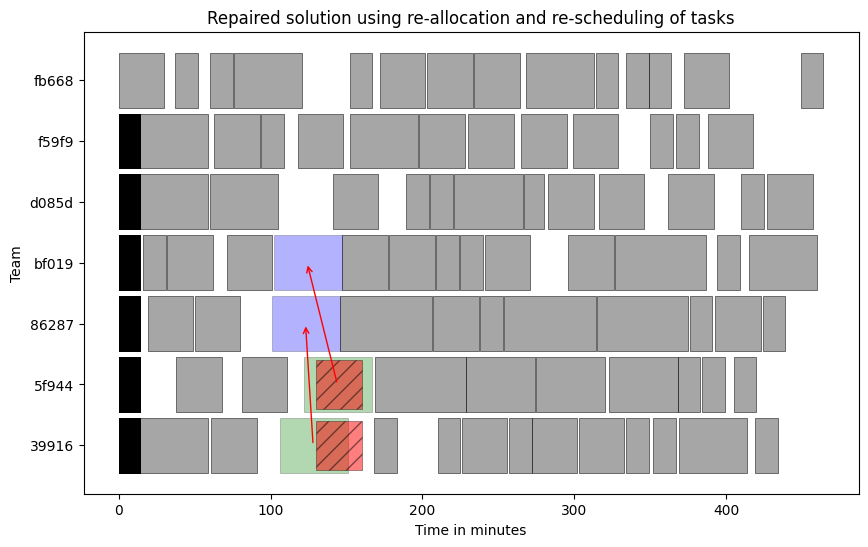

In [8]:
fig, ax = model.visualize_repair()